In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import scienceplots
# plt.style.use(['science', 'nature','no-latex'])
import time
import pandas as pd
import traceback
import os

from hamiltonians import Hamiltonian
from qnute_params import QNUTE_params as Params
from qnute_output import QNUTE_output as Output
from qnute import qnute

from helpers import *

# Figures for the paper
## 1. Fidelity to Normalized Time Evolution
This series of figures should explore the fidelity of the simulated time evolution compared to the normalized time evolution (with Taylor series). Each graph should cover a large number of randomized $k$-local Hamiltonians. The lines on the graph show the mean fidelity of the state at time t in the evolution, showing standard deviations at fixed intervals. Different lines correspond to choosing different parameters `D`, `dt`, `trotter_flag`, `taylor_truncate_a`, `taylor_truncate_h`.
For a given qubit lattice and locality $k$, a uniformly random unit-length Hamiltonian is chosen by taking randomly generated $X_I \sim \mathcal{N}(0,1)$ sampled from the standard normal distribution for each $\hat{\sigma}_I$ that can contribute to a $k$-local Hamiltonian, and normalizing the random vector $Y_I = \frac{X_I}{\sum_I X_I^2}$, and lastly generating uniform random phases $\Phi_I \sim U(0,2\pi)$ giving the coefficients $e^{i\Phi_I}Y_I$.

The graphs will be Fidelity (y-axis) vs Simulation time (x-axis) line graphs with different colors corresponding to different parameters chosen.

## 2. Fidelity variation due to measurement samples
This series of figures shows how changing the number of measurement samples in the QNUTE simulation to generate the system of linear equations in each Trotter step affects the fidelity of the simulation when compared to taking the theoretical expected values with knowledge of the state vector.

As before, each plot corresponds to a different Hamiltonian structure. We will also separate plots by the different run parameters to see if they affect the fidelity.

These should be mulit-bar graphs with error bars. Each set of bars corresponds to a number of measurement samples and the different bars in the set indicate the different run parameters, along with an aggregate over all the experiments.

Fidelity (y-axis) vs Number of Samples (x-axis, log scale)

### Generating Random k-local Hamiltonians
Ideas for how to find all possible connected paths of length $k$ in the lattice of $N$ points.
1. Loop through all possibilities of $k$ points and see if they form a connected path. $O(N^k)$ Very inneficient.
2. Loop through every point and recursively build all possible paths of length k starting from that point. $O(N2^{d(k-1)})$

Coordinate ordering by index i.e. $(0,0)\prec(0,1)\prec(1,0)\prec(1,1)$

In an unbounded grid, there will be a total of $1\cdot2^d\cdot(2^d-1)^{k-1} = O(2^{dk})$ paths of length $k>0$ originating from a fixed starting point that don't self intersect. A path of length $k$ has $k+1$ vertices in it.

In [2]:
def get_paths(start, depth,d,l, illegal_dir=None):
    '''
    returns all paths of depth=depth originating from the point start in the l^d lattice using depth first search
    the paths are sorted coordinate wise
    '''
    if type(start) is not tuple:
        start = (start, )
    assert len(start) == d, 'start must be a d-dimensional tuple'
    
    if depth == 0:
        return [[start]]  if d > 1 else [[start[0]]]
    
    paths = []
    for i in range(d):
        for j in range(2):
            if illegal_dir == (i,(-1)**j):
                continue
            n_node = list(start)
            n_node[i] += (-1)**j
            n_node = tuple(n_node)
            if in_lattice(n_node,d,l):
                n_paths = get_paths(n_node, depth-1, d,l, illegal_dir=(i,(-1)**(j+1)))
                for path in n_paths:
#                     paths.append( [start]+path )
                    paths.append( [start if d > 1 else start[0]]+path )
                    
    return paths

def get_k_local_domains(k,d,l):
    domains = set()
    for i in range(l**d):
        point = tuple(int_to_base(i,l,d))
        for k_ in range(k):
            n_paths = get_paths(point,k_,d,l)
#             print('point:{}, k={}, paths={}'.format(point, k_, n_paths))
            for path in n_paths:
                s_path = sorted(path)
                domains.add(tuple(s_path))
    return sorted(list(domains))

def get_random_complex_vector(n):
    '''
    generates a uniformly random complex vector in C^n
    '''
    x = np.random.normal(size=n)
    x /= np.linalg.norm(x)
    phi = np.random.uniform(low=-np.pi, high=np.pi,size=n)
    return np.exp(1j*phi)*x

def get_random_k_local_hamiltonian(k, d, l, qubit_map, domains=None):
    if domains is None:
        domains = get_k_local_domains(k, d, l)
    
    hm_list = [ [ [], np.zeros(3**len(domain),dtype=complex), list(domain) ] for domain in domains ]
    num_coeffs = 0
    for hm in hm_list:
        ndomain = len(hm[2])
        num_coeffs += 3**ndomain
        for p in range(3**ndomain):
            pstring = int_to_base(p, 3, ndomain)
            for i in range(ndomain):
                pstring[i] += 1
            hm[0].append(base_to_int(pstring, 4))
    coeffs = get_random_complex_vector(num_coeffs)
    start = 0
    for hm in hm_list:
        hm[1] = coeffs[start:start+len(hm[1])]
        start += len(hm[1])
    
    return Hamiltonian(hm_list, d, l, qubit_map)

def save_numerical_evolution(H_mat, psi0, dt, N, path:str):
    times = np.arange(0,N+1,1)*dt
    svs = np.zeros((N+1, psi0.shape[0]),dtype=complex)
    for i in range(len(times)):
        svs[i] = exp_mat_psi(H_mat*times[i], psi0)
        svs[i] /= np.linalg.norm(svs[i])
    rdf = pd.DataFrame(np.real(svs))
    idf = pd.DataFrame(np.imag(svs))
    rdf.insert(0,'t',times)
    idf.insert(0,'t',times)
    rdf = rdf.sort_values('t')
    idf = idf.sort_values('t')
    
    if not os.path.exists(path):
        os.makedirs(path)
    rdf.to_csv(path+'num_statevectors_real.csv',index=False)
    idf.to_csv(path+'num_statevectors_imag.csv',index=False)
    return svs

# Generating the Random Hamiltonians and Running the QNUTE experiments

In [3]:
def get_statevectors_from_csv(file):
    rdf = pd.read_csv(file+'_real.csv')
    idf = pd.read_csv(file+'_imag.csv')
    return rdf.drop('t',axis=1).to_numpy() + 1.0j * idf.drop('t',axis=1).to_numpy()

In [12]:
num_expts = 10
digits = int(np.floor(np.log10(num_expts))+1)
if digits < 3:
    digits = 3
    
original_stdout = sys.stdout

separator = '------\n'

# Hamiltonian Properties
k=2
d=1
l=2
qubit_map=None
domains = get_k_local_domains(k,d,l)

# QNUTE Parameters
# List containing the different parameters to loop through for each random Hamiltonian

# Unitary domain diameters
Ds=[1,2]

# Total simulated time T=N*dt
T = 1.0
dts = np.array([0.1,0.05,0.01])
Ns=np.ceil(T/dts).astype(int)

# Regularizer
delta = 0.1

# Number of measurement samples
# ensure that the first element is 0
num_shots = [0,1,10,100,1000]

# Use a taylor series to calculate the norm c= || e^{h_m dt}|psi> ||
taylor_norm_flag=False
taylor_truncate_h=-1

# When to truncate the Taylor series for the unitary updates
taylor_truncate_a=-1
# Whether to use a Trotterized update or not
trotter_flags=[False,True]

backend=None
init_sv = np.zeros(2**(l**d),dtype=complex)
init_sv[0] = 1.0
objective_meas_list = []

In [16]:
ham_string = 'd={}/l={}/k={}/'.format(d,l,k)

In [13]:
# What file to log to
run_id = ''

# If the run_id is blank then it will be replaced with the current date and time
run_id = run_id.strip()
if len(run_id) == 0:
    t = time.localtime()
    # current_time = time.strftime('%Y-%m-%d-%H-%M-%S',t)
    run_id = time.strftime('%Y-%m-%d',t)
ham_string = 'd={}/l={}/k={}/'.format(d,l,k)
log_path = './logs/' + ham_string + run_id + '/'

log_file = 'test.log'

if not os.path.exists(log_path):
    os.makedirs(log_path)
f = open(log_path+log_file,'w')
try:
    # redirect all print statements to the log file
    sys.stdout = f

    print('Total number of experiments:', num_expts)
    print('k={}, lattice_dim={}, lattice_bound={}'.format(k,d,l))
    print('Qubit mapping:')
    if qubit_map is None:
        print('\tDefault 1-D mapping')
    else:
        for key in qubit_map.keys():
            print('\t{} -> {},'.format(key, qubit_map[key]))
    if objective_meas_list is None or len(objective_meas_list) == 0:
        print('No objective measurements')
    else:
        print('List of objective measurements:')
        for m_list in objective_meas_list:
            qbits = m_list[1]
            for p in m_list[0]:
                pstring = int_to_base(p,4,len(qbits))
                m_name = ''
                for i in range(len(qbits)):
                    if pstring[i] == 0: m_name += 'I'
                    else: m_name += chr(ord('X')+pstring[i]-1)
                    m_name += '_'
                    m_name += str(qbits[i])
                    if i < len(qbits) - 1: m_name += ' '
                print('\t{},'.format(m_name))

    print(separator)

    for i in range(num_expts):
        t1 = time.localtime()
        print('Started Experiment #{} at {}'.format(format(i+1,'0{}d'.format(digits)), time.strftime('%I:%M:%S %p, %d %b %Y', t1)))
        expt_path = log_path + 'expt_{}/'.format(format(i+1,'0{}d'.format(digits)))
        if not os.path.exists(expt_path):
            os.makedirs(expt_path)

        H = get_random_k_local_hamiltonian(k,d,l,qubit_map,domains)
        print('Randomly Generated Effective Hamiltonian:')
        H.print()
        H.to_csv(expt_path+'ham.csv')
        print('Saved Hamiltonian description in \'{}ham.csv\''.format(expt_path))
        print(separator)

        params = Params(H)
        for t_i in range(len(dts)):
            dt = dts[t_i]
            N  = Ns[t_i]
            t = np.arange(0,N+1,1)*dt
            print('Numerically calculating normalized non-unitary evolution')
            num_svs = save_numerical_evolution(H.get_matrix(), init_sv, dt, N, expt_path+'/dt={}/'.format(dt))
            print(separator)
            for D in Ds:
                params.load_hamiltonian_params(D,False,True)
                for trotter in trotter_flags:
                    for shots in num_shots:
                        print('Setting QNUTE run parameters:')
                        print('\tD={}'.format(D))
                        print('\tdt={}'.format(dt))
                        print('\tdelta={}'.format(delta))
                        print('\tN={}'.format(N))
                        print('\tnum_shots={}'.format(shots))
                        print('\ttaylor_norm_flag={}'.format(taylor_norm_flag))
                        print('\ttaylor_truncate_h={}'.format(taylor_truncate_h))
                        print('\ttaylor_truncate_a={}'.format(taylor_truncate_a))
                        print('\ttrotter_flag={}'.format(trotter))
                        params.set_run_params(dt,delta,N,shots,backend,
                                              init_sv=init_sv,
                                              taylor_norm_flag=taylor_norm_flag, 
                                              taylor_truncate_h=taylor_truncate_h, 
                                              taylor_truncate_a=taylor_truncate_a, 
                                              trotter_flag=trotter,
                                              objective_meas_list=objective_meas_list)
                        instance_path = expt_path + 'dt={}/D={}/trotter={}/shots={}/'.format(dt,D,trotter,shots)
                        if not os.path.exists(instance_path):
                            os.makedirs(instance_path)

                        print('Started QNUTE instance at', time.strftime('%I:%M:%S %p, %d %b %Y',time.localtime()))
                        output = qnute(params, log_to_console=True)
                        print('Finished QNUTE instance at', time.strftime('%I:%M:%S %p, %d %b %Y',time.localtime()))

                        output.log_output('run', path=instance_path)
                        print('Saved QNUTE outputs in \'{}\''.format(instance_path))
                        
                        print('Calculating fidelities')
                        fids = np.abs(np.diag( num_svs.conj() @ output.svs.T ))
                        fid_df = pd.DataFrame(data = {'t':t, 'Fidelity': fids})
                        fid_df.to_csv(instance_path+'fidelity_to_taylor.csv',index=False)
                        
                        if shots == 0:
                            s0_svs = get_statevectors_from_csv(instance_path+'run_statevectors')
                        if shots > 0:
                            # Compare to the shots=0 run with the same parameters
                            fids = np.abs(np.diag( s0_svs.conj() @ output.svs.T ))
                            fid_df = pd.DataFrame(data = {'t':t, 'Fidelity': fids})
                            fid_df.to_csv(instance_path+'fidelity_to_0_shots.csv',index=False)
                        print(separator)

        t2 = time.localtime()
        print('Finished Experiment #{} at {}'.format(format(i+1,'0{}d'.format(digits)), time.strftime('%I:%M:%S %p, %d %b %Y', t2)))
        print(separator)

    print('Finished execution at {}'.format(time.strftime('%I:%M:%S %p, %d %b %Y', time.localtime())))
except Exception as e:
    print(separator)
    print('{}: {}'.format(type(e).__name__, e))
    print(traceback.format_exc())
    t = time.localtime()
    print('Terminating run at', time.strftime('%I:%M:%S %p, %d %b %Y', t))
finally:
    # reset stdout to the console
    sys.stdout = original_stdout
    f.close()

C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox N

C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox Notebooks\..\helpers.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(points,axis=0)/n
C:\Users\swaga\Documents\QNUTE\Sandbox N

# Generate data for the fidelity graphs:
Loop through the folder structure to aggregate the fidelities

In [111]:
fig_data_string = 'figure_data/'
fig_data_path = log_path + fig_data_string

for D in Ds:
    first_flag = True
    for t_i in range(len(dts)):
        dt = dts[t_i]
        N = Ns[t_i]
        for trotter in trotter_flags:
            for shots in num_shots:
                instance_string = 'dt={}/D={}/trotter={}/shots={}/'.format(dt,D,trotter,shots)
                data_path = fig_data_path + instance_string
                if not os.path.exists(data_path):
                    os.makedirs(data_path)
                for i in range(num_expts):
                    expt_path = log_path + 'expt_{}/'.format(format(i+1,'0{}d'.format(digits)))
                    instance_path = expt_path + instance_string
                    if i == 0:
                        taylor_fid_df = pd.read_csv(instance_path+'fidelity_to_taylor.csv',names=['t','f1'],header=0)
                    else:
                        taylor_fid_df = taylor_fid_df.join(pd.read_csv(instance_path+'fidelity_to_taylor.csv',usecols=['f{}'.format(i+1)],names=['t','f{}'.format(i+1)],header=0))
                
                taylor_mean_df = taylor_fid_df.filter(like='f').agg((np.mean, np.std), axis=1, ddof=0)
                taylor_mean_df.insert(0,'t',taylor_fid_df['t'])
                taylor_mean_df.to_csv(data_path+'mean_fidelity_to_taylor.csv',index=False)
                
                if shots == 0:
                    if first_flag:
                        all_taylor_mean_df = taylor_mean_df.copy().rename(columns={'mean':instance_string+'mean', 'std': instance_string+'std'})
                        first_flag = False
                    else:
                        all_taylor_mean_df = all_taylor_mean_df.join(taylor_mean_df.drop('t',axis=1).rename(columns={'mean':instance_string+'mean', 'std':instance_string+'std'}))
                
                if shots > 0:
                    for i in range(num_expts):
                        expt_path = log_path + 'expt_{}/'.format(format(i+1,'0{}d'.format(digits)))
                        instance_path = expt_path + instance_string
                        if i == 0:
                            s0_fid_df = pd.read_csv(instance_path+'fidelity_to_0_shots.csv',names=['t','f1'],header=0)
                        else:
                            s0_fid_df = s0_fid_df.join(pd.read_csv(instance_path+'fidelity_to_0_shots.csv',usecols=['f{}'.format(i+1)],names=['t','f{}'.format(i+1)],header=0))
                    # Timewise mean and std
                    t_s0_mean_df = s0_fid_df.filter(like='f').agg((np.mean, np.std),axis=1,ddof=0)
                    t_s0_mean_df.insert(0,'t',s0_fid_df['t'])
                    t_s0_mean_df.to_csv(data_path+'timewise_mean_fidelity_to_0_shots.csv',index=False)
                    
                    #Overall mean and std
                    if shots == num_shots[1]:
                        all_s0_mean_df = pd.DataFrame(s0_fid_df.filter(like='f').stack().agg((np.mean,np.std),ddof=0),columns=[shots])
                    else:
                        all_s0_mean_df.insert(0,shots,s0_fid_df.filter(like='f').stack().agg((np.mean,np.std),ddof=0))
            # Overall mean and std wrt number of shots
            all_s0_mean_df.to_csv(fig_data_path+ 'dt={}/D={}/trotter={}/'.format(dt,D,trotter)+'overall_mean_fidelity_to_0_shots.csv')

In [199]:
all_taylor_mean_df

,t,dt=0.1/D=2/trotter=False/shots=0/mean,dt=0.1/D=2/trotter=False/shots=0/std,dt=0.1/D=2/trotter=True/shots=0/mean,dt=0.1/D=2/trotter=True/shots=0/std,dt=0.05/D=2/trotter=False/shots=0/mean,dt=0.05/D=2/trotter=False/shots=0/std,dt=0.05/D=2/trotter=True/shots=0/mean,dt=0.05/D=2/trotter=True/shots=0/std,dt=0.01/D=2/trotter=False/shots=0/mean,dt=0.01/D=2/trotter=False/shots=0/std,dt=0.01/D=2/trotter=True/shots=0/mean,dt=0.01/D=2/trotter=True/shots=0/std
0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.1,0.997143,0.001825,0.997143,0.001827,0.999287,0.000445,0.999287,0.000445,0.999972,0.000017,0.999972,0.000017
2,0.2,0.988600,0.007647,0.988598,0.007655,0.997143,0.001826,0.997143,0.001827,0.999886,0.000070,0.999886,0.000070
3,0.3,0.974638,0.017844,0.974635,0.017859,0.993572,0.004209,0.993571,0.004212,0.999744,0.000159,0.999744,0.000159
4,0.4,0.955822,0.032483,0.955818,0.032504,0.988598,0.007651,0.988597,0.007655,0.999544,0.000283,0.999544,0.000283
5,0.5,0.932968,0.051240,0.932965,0.051266,0.982265,0.012192,0.982264,0.012198,0.999287,0.000445,0.999287,0.000445
6,0.6,0.907066,0.073431,0.907068,0.073456,0.974635,0.017853,0.974633,0.017861,0.998973,0.000644,0.998973,0.000644
7,0.7,0.879168,0.098115,0.879181,0.098132,0.965787,0.024630,0.965786,0.024640,0.998601,0.000882,0.998601,0.000882
8,0.8,0.850283,0.124247,0.850310,0.124247,0.955818,0.032496,0.955816,0.032507,0.998172,0.001157,0.998172,0.001158
9,0.9,0.821279,0.150821,0.821328,0.150793,0.944837,0.041398,0.944835,0.041410,0.997686,0.001472,0.997686,0.001473


In [114]:
all_taylor_mean_df.to_csv('test.csv',index=False)
df = pd.read_csv('test.csv')

In [115]:
df.columns

Index(['t', 'dt=0.1/D=2/trotter=False/shots=0/mean',
       'dt=0.1/D=2/trotter=False/shots=0/std',
       'dt=0.1/D=2/trotter=True/shots=0/mean',
       'dt=0.1/D=2/trotter=True/shots=0/std',
       'dt=0.05/D=2/trotter=False/shots=0/mean',
       'dt=0.05/D=2/trotter=False/shots=0/std',
       'dt=0.05/D=2/trotter=True/shots=0/mean',
       'dt=0.05/D=2/trotter=True/shots=0/std',
       'dt=0.01/D=2/trotter=False/shots=0/mean',
       'dt=0.01/D=2/trotter=False/shots=0/std',
       'dt=0.01/D=2/trotter=True/shots=0/mean',
       'dt=0.01/D=2/trotter=True/shots=0/std'],
      dtype='object')

In [141]:
for l in labels:
    lsplit = l.split('/')
    lab = '{}, {}'.format(lsplit[0],lsplit[2])
    print(lab)

dt=0.1, trotter=False
dt=0.1, trotter=True
dt=0.05, trotter=False
dt=0.05, trotter=True
dt=0.01, trotter=False
dt=0.01, trotter=True


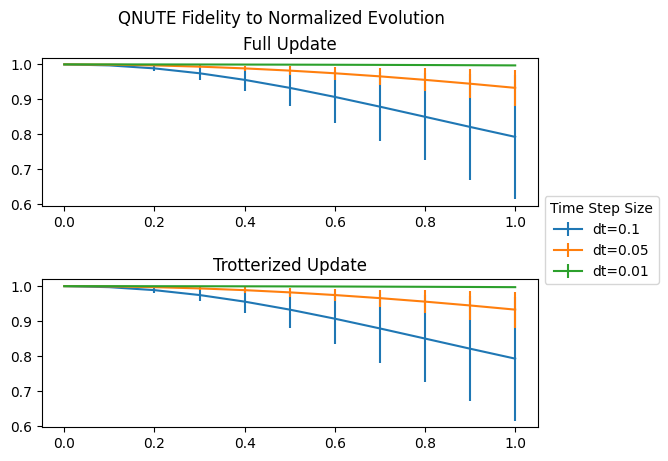

In [198]:
cols = df.columns
labels = []
for i in range((len(cols) - 1)//2):
    l = cols[2*i+1].split('/')
    labels.append('{}'.format(l[0],l[2]))
fig,axs = plt.subplots(2,1)
for i in range(1,len(cols),4):
    axs[0].errorbar( df['t'], df[cols[i]], yerr=df[cols[i+1]], label=labels[(i-1)//2], markevery=1 )
for i in range(3,len(cols),4):
    axs[1].errorbar( df['t'], df[cols[i]], yerr=df[cols[i+1]], label=labels[(i-1)//2], markevery=1 )

handles,labs = axs[1].get_legend_handles_labels()
fig.subplots_adjust(hspace=0.5)
fig.suptitle('QNUTE Fidelity to Normalized Evolution')
axs[0].set_title('Full Update')
axs[1].set_title('Trotterized Update')
fig.legend(handles, labs, loc='center left', bbox_to_anchor=(0.9,0.5),title='Time Step Size')
plt.show()

# Read the figure data to generate the figures

In [73]:
figure_path = './figs/' + ham_string + run_id + '/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
for t_i in range(len(dts)):
    dt = dts[t_i]
    N = Ns[t_i]
    for D in Ds:
        for trotter in trotter_flags:
#             instance_string = 'dt={}/D={}/trotter={}/'.format(dt,D,trotter)
#             if not os.path.exists(figure_path + instance_string):
#                 os.makedirs(figure_path + instance_string)
#             all_s0_mean_df = pd.read_csv(fig_data_path + instance_string + 'overall_mean_fidelity_to_0_shots.csv',header=0,index_col=0)
#             plot_s0_fidelity_bars(all_s0_mean_df, figure_path+instance_string)
            for shots in num_shots:
                instance_string = 'dt={}/D={}/trotter={}/shots={}/'.format(dt,D,trotter,shots)
                data_path = fig_data_path + instance_string
                if shots == shots[0]:
                    taylor_mean_df = pd.read_csv(data_path + 'mean_fidelity_to_taylor.csv', )
                    

In [74]:
df = taylor_mean_df

In [75]:
df

,t,mean,std
0,0.00,1.000000,0.000000
1,0.01,0.999972,0.000017
2,0.02,0.999886,0.000070
3,0.03,0.999744,0.000158
4,0.04,0.999544,0.000283
...,...,...,...
96,0.96,0.804105,0.166561
97,0.97,0.801276,0.169175
98,0.98,0.798459,0.171755
99,0.99,0.795654,0.174334


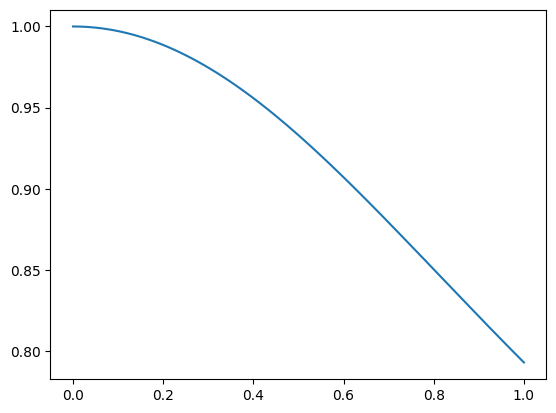

In [78]:
plt.plot(df['t'], df['mean'])

In [70]:
def plot_s0_fidelity_bars(df, fig_path, ymin=0.8, dpi=300):
    y_data = list(df.loc['mean'])[::-1]
    y_error = list(df.loc['std'])[::-1]

    x_labels = list(df.columns)[::-1]
    x_points = np.arange(len(x_labels))

    fig,ax = plt.subplots()
    ax.bar(x_points, y_data, yerr=y_error,alpha=0.5,capsize=10)

    ax.set_xticks(x_points)
    ax.set_xticklabels(x_labels)
    ax.set_ylim(ymin,1.05)
    ax.set_yticks(np.arange(0.8,1.05,0.05))

    ax.yaxis.grid(True)
    ax.set_xlabel('Measurement Samples per Observable')
    ax.set_ylabel('Fidelity')
    ax.set_title('Mean Fidelity to QNUTE using Theoretical Observable Expectations')
    ax.set_facecolor('white')
    plt.savefig(fig_path + 'overall_mean_fidelity_to_0_shots.png',dpi=dpi)
    plt.close()